## Sample test simulation

This notebook contains the basic syntax required to run a chain. We set up a mock data object from a test sim, construct an emulator and likelihood object, and pass these to a sampler to run for a small number of steps.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams["savefig.dpi"] = 140
mpl.rcParams["figure.dpi"] = 140
import numpy as np
import time
import os

# our own modules
from lace.archive import gadget_archive, nyx_archive
from lace.emulator import gp_emulator, nn_emulator
from cup1d.data import data_gadget, data_nyx
from cup1d.likelihood import lya_theory, likelihood, emcee_sampler
from lace.cosmo import camb_cosmo
from cup1d.scripts.launch_sam_sim import Args
from cup1d.scripts.sam_sim import (
    set_archive,
    set_emu,
    set_p1ds,
    set_fid_cosmo,
    set_like,
    sample,
    path_sampler,
    set_log_prob,
)


def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        return False

warning in stationary: failed to import cython module: falling back to numpy
warning in coregionalize: failed to import cython module: falling back to numpy
warning in choleskies: failed to import cython module: falling back to numpy


In [2]:
import black
import jupyter_black

jupyter_black.load(
    lab=False,
    line_length=79,
    verbosity="DEBUG",
    target_version=black.TargetVersion.PY310,
)


DEBUG:jupyter_black:Using config from /home/jchaves/Proyectos/projects/lya/cup1d/pyproject.toml
DEBUG:jupyter_black:config: {'line_length': 79, 'target_versions': {<TargetVersion.PY310: 10>}}


<IPython.core.display.Javascript object>

### Set up arguments

In [6]:
args = Args()
args.emulator_label = "Nyx_v0"
args.training_set = "Nyx23_Oct2023"
args.mock_sim_label = "mpg_central"
args.igm_sim_label = "mpg_central"
args.cosmo_sim_label = "mpg_central"
# args.emulator_label = "Cabayol23"
# args.training_set = "Cabayol23"
# args.mock_sim_label = "nyx_central"
# args.igm_sim_label = "nyx_central"
# args.cosmo_sim_label = "nyx_central"
args.add_noise = False
args.drop_sim = False
args.use_polyfit = True
args.n_igm = 0
args.cov_label = "Chabanier2019"
args.verbose = True
args.version = "v2"
args.parallel = False
args.z_max = 4.5
args.fix_cosmo = False

args.n_steps = 100
if args.n_igm == 0:
    args.n_burn_in = 100
else:
    args.n_burn_in = 500

In [7]:
archive = set_archive(args)

In [8]:
emulator = set_emu(
    archive,
    args.training_set,
    args.emulator_label,
    args.mock_sim_label,
    args.drop_sim,
)

if args.use_polyfit:
    args.polyfit_kmax_Mpc = emulator.kmax_Mpc
    args.polyfit_ndeg = emulator.ndeg
else:
    args.polyfit_kmax_Mpc = None
    args.polyfit_ndeg = None

Loading emulator Nyx_v0
Selected training set from Nyx23_Oct2023
Select emulator in Nyx_v0
Neural network emulating the optimal P1D of Nyx simulations fitting coefficients to a 5th degree polynomial. It goes to scales of 4Mpc^{-1} and z<=4.5. The parameters passed to the emulator will be overwritten to match these ones
Model loaded. No training needed


In [9]:
data, extra_data = set_p1ds(args, archive)
archive = None

In [10]:
cosmo_fid = set_fid_cosmo(args)

In [11]:
like = set_like(args, emulator, data, extra_data, cosmo_fid)

----------
Set likelihood
Using 0 parameters for IGM model
free parameters ['As', 'ns']


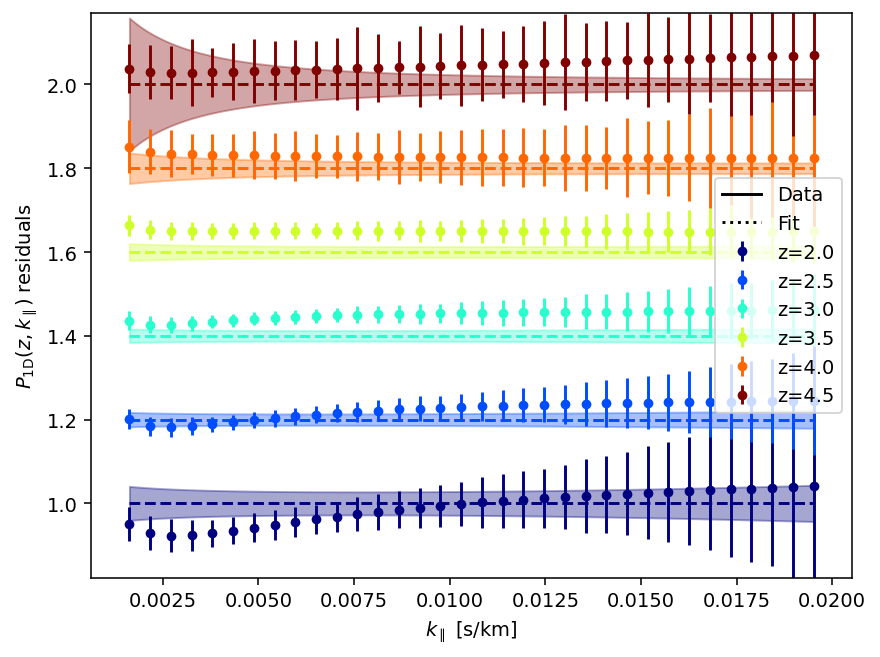

In [12]:
like.plot_p1d(residuals=True, plot_every_iz=2)

In [13]:
for p in like.free_params:
    print(p.name, p.value, p.min_value, p.max_value)

As 2.006055e-09 7.4e-10 4.11e-09
ns 0.967565 0.68 1.32


In [14]:
path = path_sampler(args)
print("\n\n Output in folder: " + path + "\n\n")

sampler = emcee_sampler.EmceeSampler(
    like=like,
    rootdir=path,
    save_chain=False,
    nburnin=args.n_burn_in,
    nsteps=args.n_steps,
    parallel=args.parallel,
)
_log_prob = set_log_prob(sampler)



 Output in folder: /home/jchaves/Proyectos/projects/lya/data/cup1d/sampler/v2/emu_Nyx_v0/cov_Chabanier2019_lres/mock_mpg_central_igm_mpg_central_cosmo_mpg_central_nigm_0_ndrop_ypoly/


Created directory: /home/jchaves/Proyectos/projects/lya/data/cup1d/sampler/v2/emu_Nyx_v0/cov_Chabanier2019_lres/mock_mpg_central_igm_mpg_central_cosmo_mpg_central_nigm_0_ndrop_ypoly//chain_1
setup with  1  ranks,  81  walkers, and  100  steps
combined steps  16200 (should be close to  16000 )


In [15]:
%%time
_emcee_sam = sampler.run_sampler(log_func=_log_prob)

set 81 walkers with 2 dimensions
Step 200 out of 200 
CPU times: user 40.7 s, sys: 9.65 ms, total: 40.7 s
Wall time: 40.7 s


Best values: [0.38554193 0.48653737]
Can't plot IGM histories
Can't plot best fit


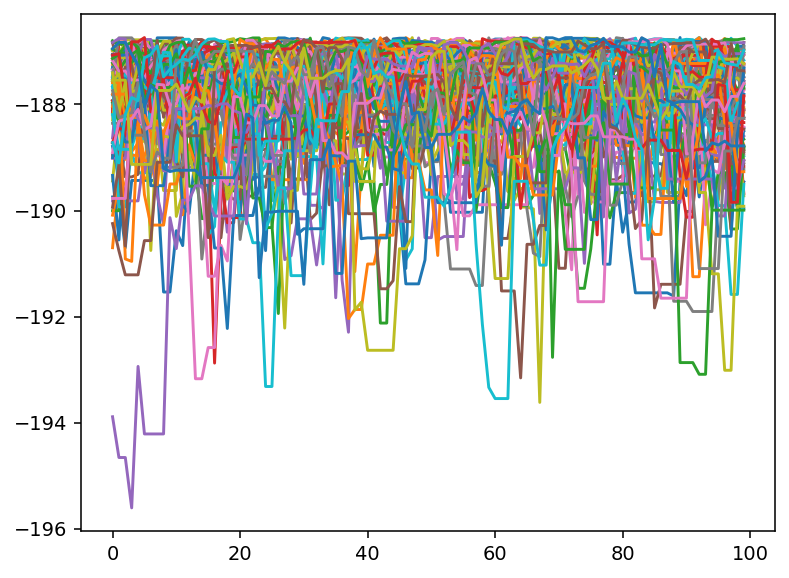

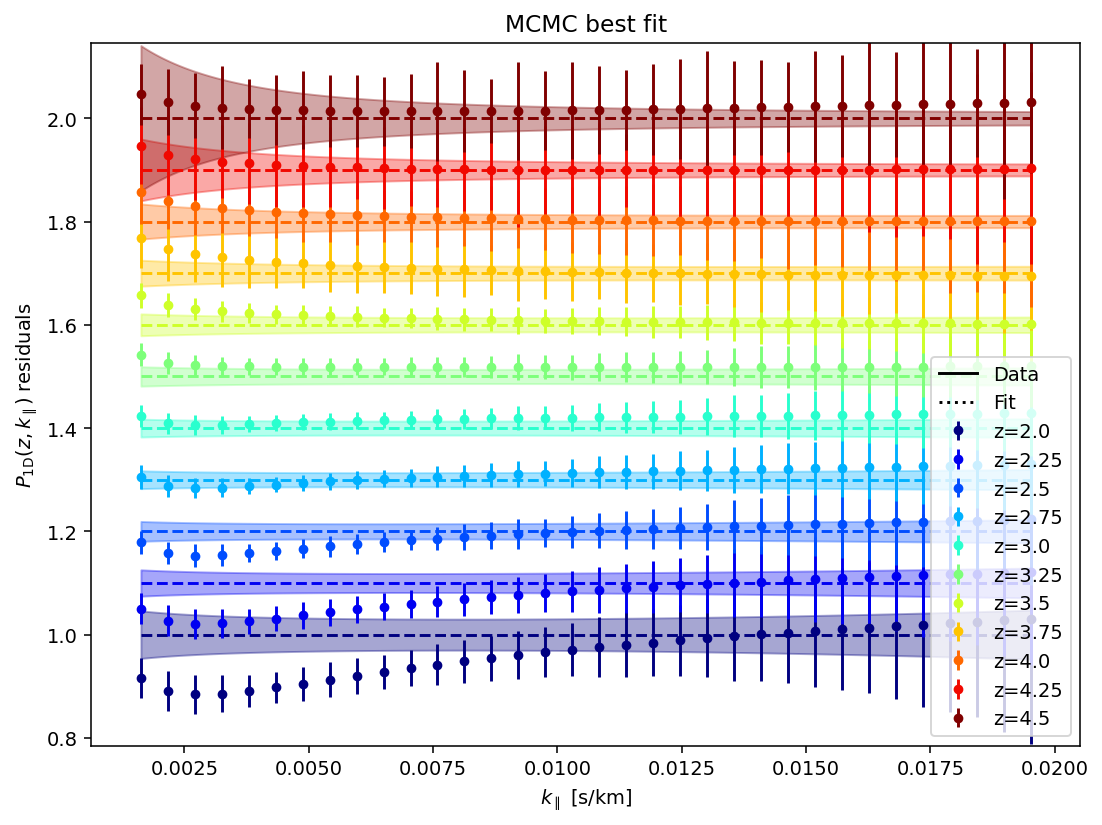

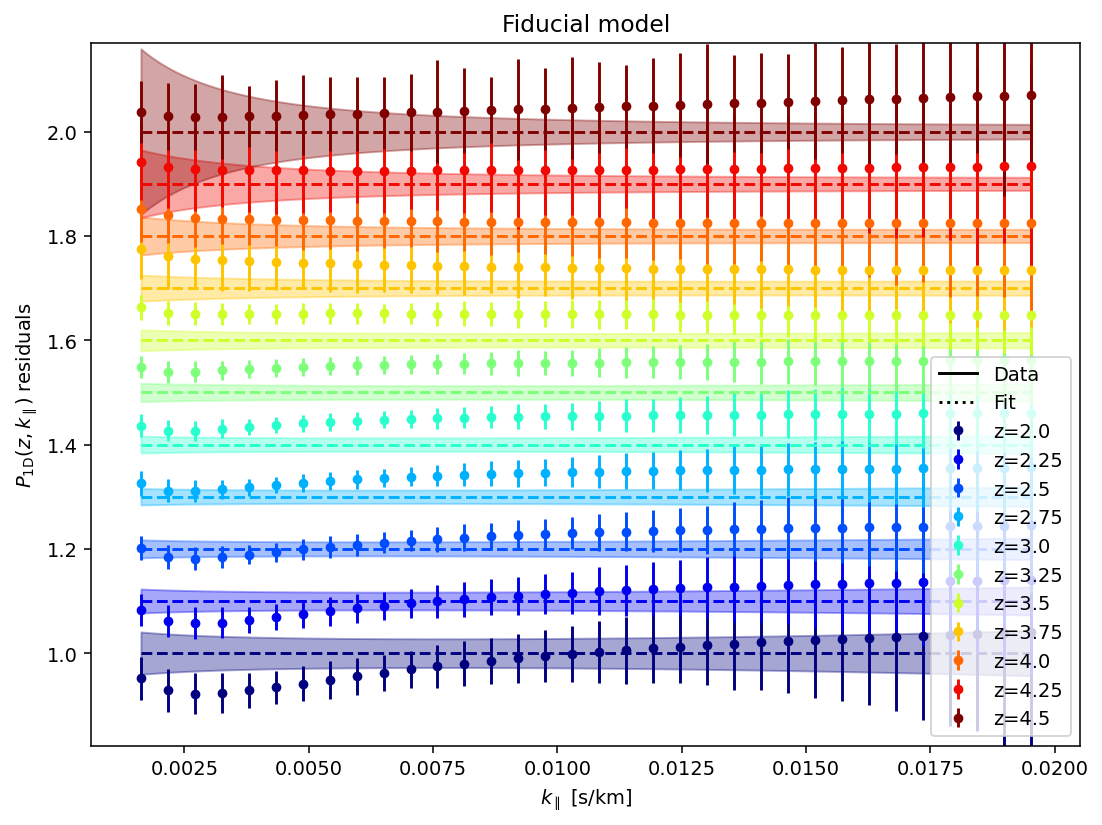

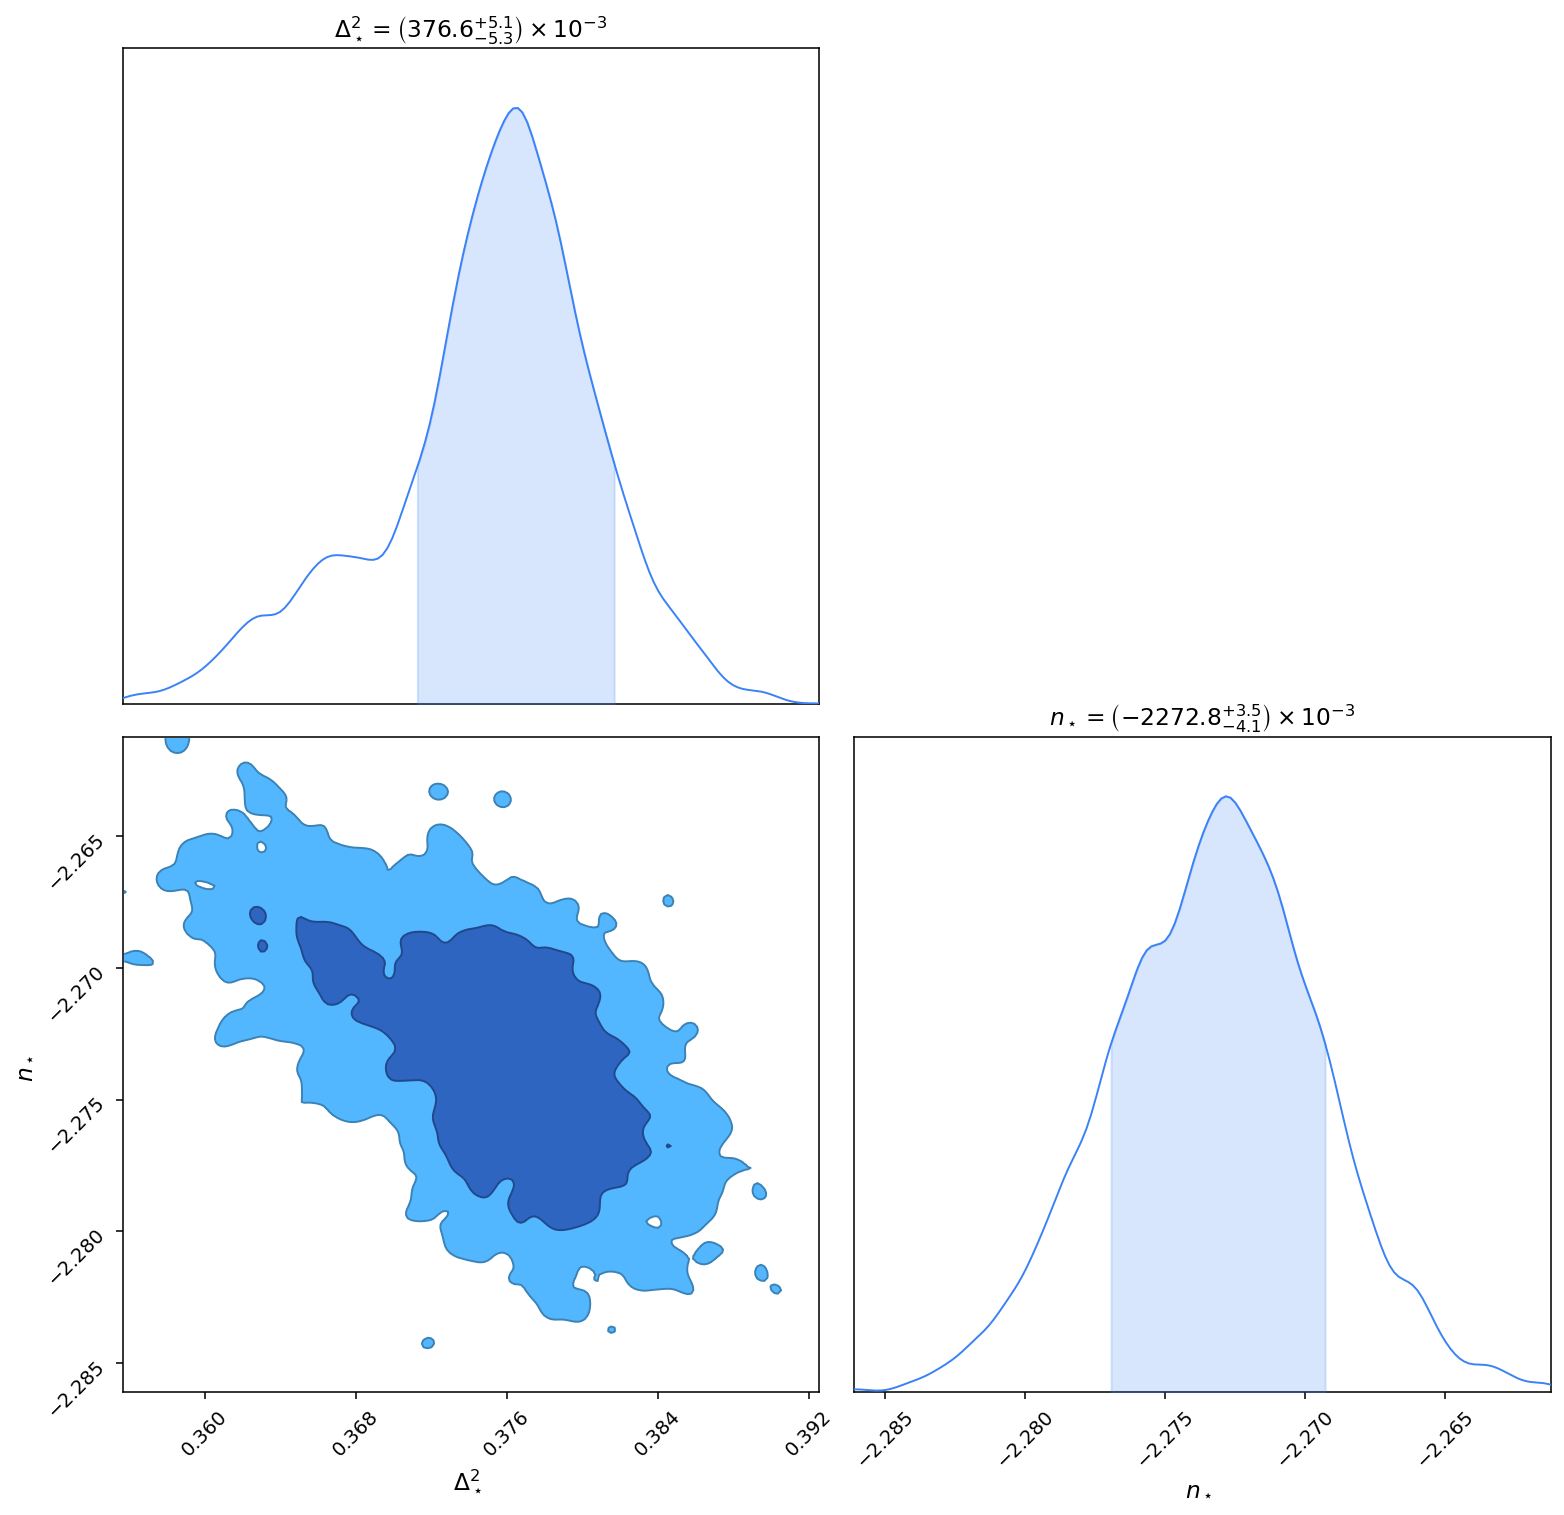

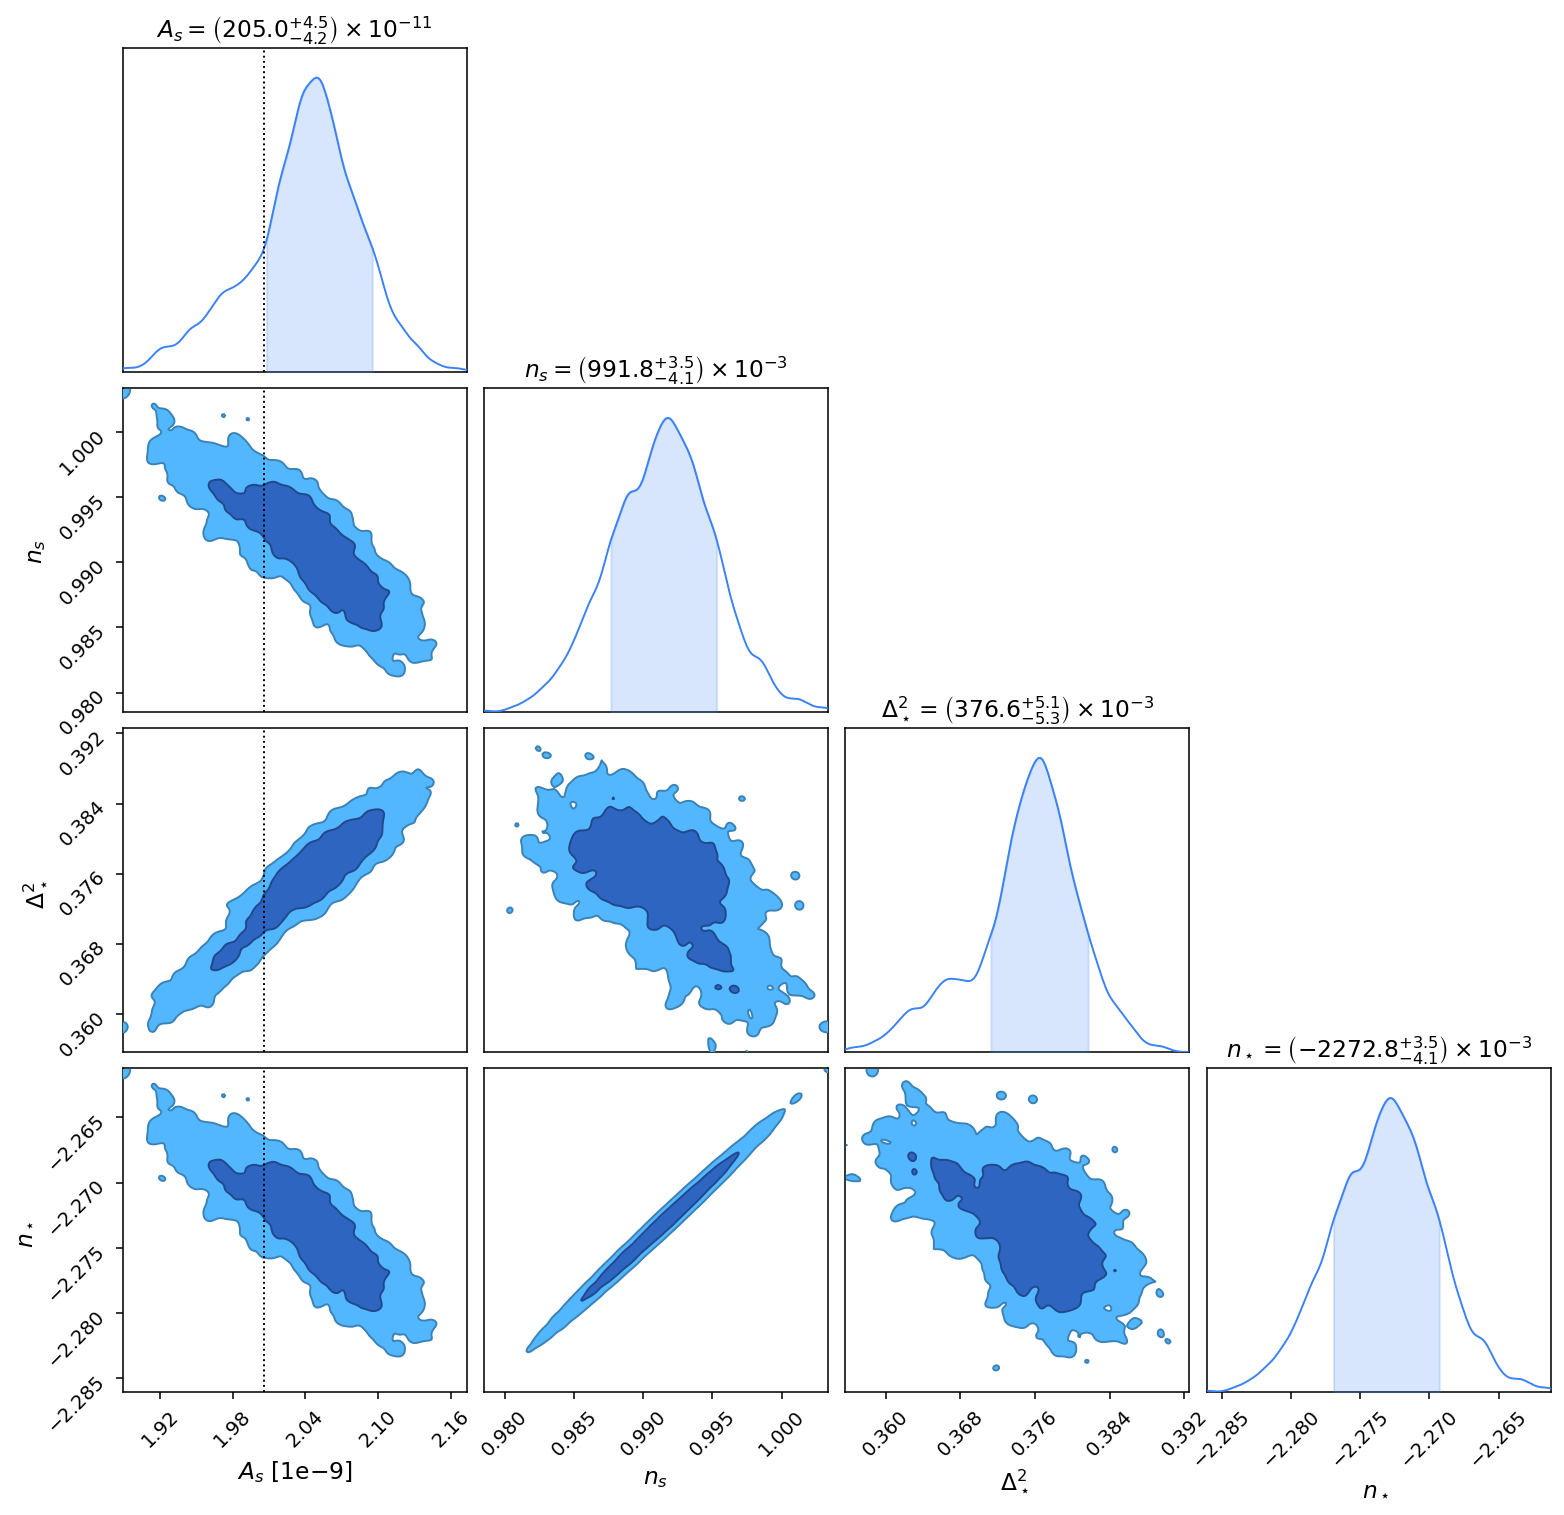

In [16]:
sampler.write_chain_to_file()

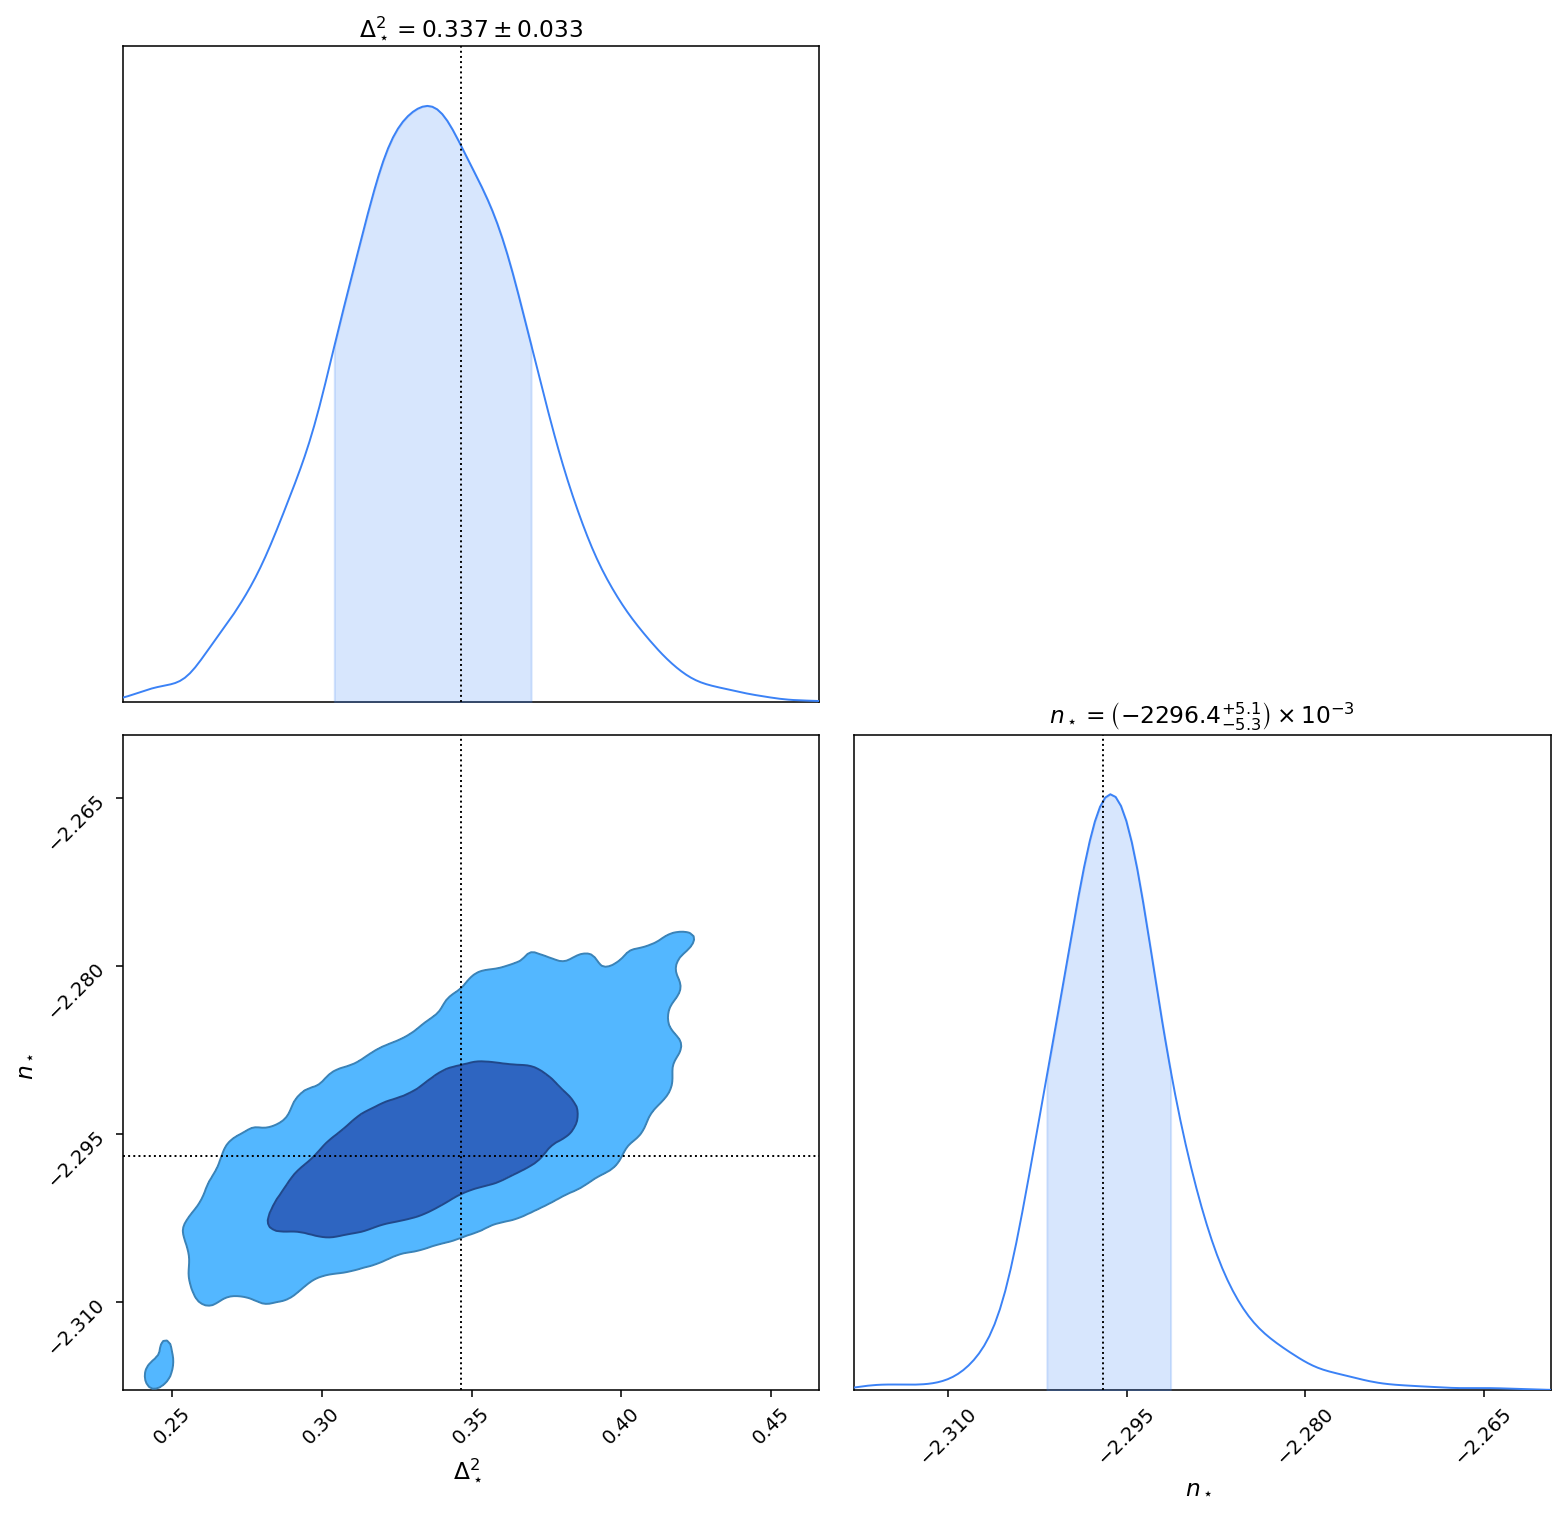

In [20]:
_ = sampler.plot_corner(only_cosmo=True)